# Import packages

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
import ot
from statsmodels.distributions.empirical_distribution import ECDF
import Prob_models as PM
import random
import scipy
from netCDF4 import Dataset

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# Set random seed for reproducibility

In [2]:
seed = 0
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Metrics

Block of code for studied metrics

### QQplot

NameError: name 'samples_y' is not defined

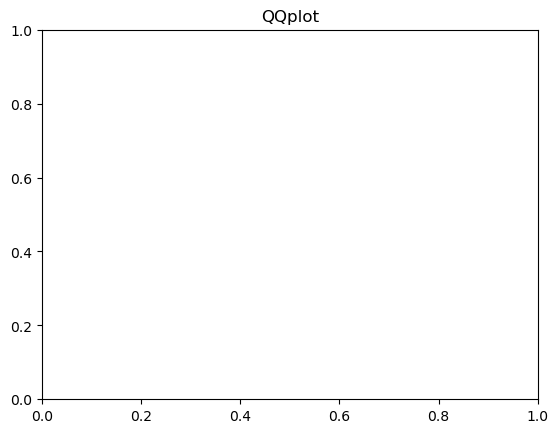

In [4]:
#QQ plot
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_rad))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

#log QQ plot
plt.figure()
plt.title('QQplot')
plt.scatter(tf.log(tf.sort(samples_y)),tf.log(tf.sort(samples_rad)))
plt.plot(tf.log(tf.sort(samples_y)),tf.log(tf.sort(samples_y)))

### KL divergence upon a threshold

In [67]:
def tail_mod(f,n,x):
    return((n/n+1)*(1-f(x))+1/(n+1))


def L(X,Y,u):
    Nn = np.sum(X>u)
    m=Y.shape[0]
    fY=ECDF(Y)
    Xmax = np.maximum(X,u)
    Xu = np.minimum(Xmax,u)
    res = 1 + 1/Nn*(np.sum(np.log(tail_mod(fY,m,Xmax)/tail_mod(fY,m,Xu))))
    return(res)
    
def K(X,Y,u):
    res = -L(X,Y,u)-L(Y,X,u)
    return res

### Wasserstein distance

In [8]:
def Wasserstein(s1,s2):
    M=ot.dist(s1,s2)
    return(ot.emd2())

### Threshold selection

In [9]:
def distmat(X):
    r = tf.reduce_sum(X*X, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(X, tf.transpose(X)) + tf.transpose(r)
    return(tf.maximum(D,0))

def T(X,Y,n):
    MX = tf.math.sqrt(distmat(X))
    MY = tf.math.sqrt(distmat(Y))
    T1 = (1/n**2)*tf.reduce_sum(tf.math.multiply(MX,MY))
    T2 = (2/n**3)*tf.reduce_sum(tf.linalg.matmul(MX,MY))
    T3 = (1/n**4)*tf.reduce_sum(tf.tensordot(MX,MY,axes=0))
    return T1-T2+T3


In [ ]:
#pvalues for given radii sorted R_sort and associated angles angle_dep

#Intervals of tested quantiles
qmax=0.15
qmin=0.4

nbq = 30 #number of tested quantiles


m=60
L=200
qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]


for i in range(nbq):
    pvi = 0
    for k in range(m):
        q = qk[i]
        n = nk[i]
        r = R1_sort[np.int((1-q)*10000)].numpy()
        Ind = tf.cast(tf.where(R>r),dtype=tf.int32)
        Rq = R[Ind]/r
        angle = angle_dep[Ind]
        IndS = np.random.permutation(Ind[0])[:np.int(n)]
        RqS_joint = (R[IndS]/r)
        shape_RqS=RqS_joint.shape[0]
        RqS_joint = tf.reshape(RqS_joint,(shape_RqS,1))
        angleS_joint = (angle_dep[IndS])
        T_emp = T(RqS_joint,angleS_joint,np.int(n))
        pvk=0
        for j in range(L):
            RqS_ind=np.random.permutation(Rq)[:np.int(n)]
            RqS_ind = np.expand_dims(RqS_ind,axis=-1)
            angleS_ind = np.random.permutation(angle)[:np.int(n)]
            T_ind = T(RqS_ind,angleS_ind,np.int(n))
            pvk+= T_emp.numpy()>(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    pvi = pvi/m
    res.append(pvi)

# Generating radii samples

In [46]:
# Synthetic dataset

#Checkpoint
checkpoint_path  = '/home/nlafon/These/Extreme_VAE/tmp/radius1/Ext_VAE/Gamma_output9/Ext_VAE_custom_outputG_fig3'
checkpoint_path2 = '/home/nlafon/These/Extreme_VAE/tmp/radius1/Std_VAE/std_VAE_checkpoint2'
checkpoint_path3 = '/home/nlafon/These/Extreme_VAE/tmp/radius1/U_Ext_VAE/Learnable_prior_3/U_Ext_VAE_checkpoint'

#VAE model selection
vae_test1 = PM.Std_VAE()
vae_test2 = PM.Ext_VAE()
vae_test3 = PM.U_Ext_VAE()

#Load model
vae_test1.load_weights(checkpoint_path2)
vae_test2.load_weights(checkpoint_path)
vae_test3.load_weights(checkpoint_path3)

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.6844304], dtype=float32)>


In [3]:
# Danube dataset 
checkpoint_path_Danube = '/home/nlafon/These/Extreme_VAE/tmp/Danube/radius/Ext_VAE/Gamma_output_prior_unknown3/checkpoint'

vae_testD = PM.Ext_VAE()
vae_testD.load_weights(checkpoint_path_Danube)

2023-01-13 15:59:12.998756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 15:59:13.001404: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# True samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set = A*X
test_set =test_set.numpy()

2023-01-17 11:33:55.302982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 11:33:55.313344: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [63]:
# Generated radii samples for synthethic dataset

prior_samples1 = vae_test1.encoder.prior.sample(N_samples)
samples_vae1 = vae_test1.decoder(prior_samples1).sample()

prior_samples2 = vae_test2.encoder.prior.sample(N_samples)
samples_vae2 = vae_test2.decoder(prior_samples2).sample()

prior_samples3 = vae_test3.encoder.prior.sample(N_samples)
samples_vae3 = vae_test3.decoder(prior_samples3).sample()


tf.Tensor(3.5224397, shape=(), dtype=float32)
tf.Tensor(-4.0256014, shape=(), dtype=float32)
tf.Tensor([2.7178605 2.3972633 0.4728036 ... 4.9615154 0.6095449 1.814621 ], shape=(10000,), dtype=float32)
tf.Tensor(9.26133, shape=(), dtype=float32)
tf.Tensor(0.0035499106, shape=(), dtype=float32)
tf.Tensor([4.6251273  0.4384576  0.08887011 ... 0.1165713  0.02862954 1.0882851 ], shape=(10000,), dtype=float32)
tf.Tensor(11.240629, shape=(), dtype=float32)
tf.Tensor(0.0043719593, shape=(), dtype=float32)
tf.Tensor(
[ 0.64769673  0.28982487  1.6158553  ...  4.3112426   2.7882044
 10.530963  ], shape=(10000,), dtype=float32)


In [4]:
#Danube dataset loading and generated radii samples from radii dataset
ncfile = Dataset('/home/nlafon/These/4Dvarnetstochastic/Danube_river_network/Dataset_danube.nc',"r")
L=[]
for i in range(31):
    L.append(ncfile['S'+str(i+1)][:].reshape(18244,1))
        
dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)
R4 = dataset[:,22:27]
axis = 1
test_set = np.sum(R4,axis)
test_set = test_set.reshape((18244,1))

prior_samples = vae_testD.encoder.prior.sample(test_set.shape)
samples_vae   = vae_testD.decoder(prior_samples).sample()

# Radius experiments

### Estimated density for true radius distribution vs our VAE approach for radius sampling

/tmp/ipykernel_92176/2358292155.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_vae)


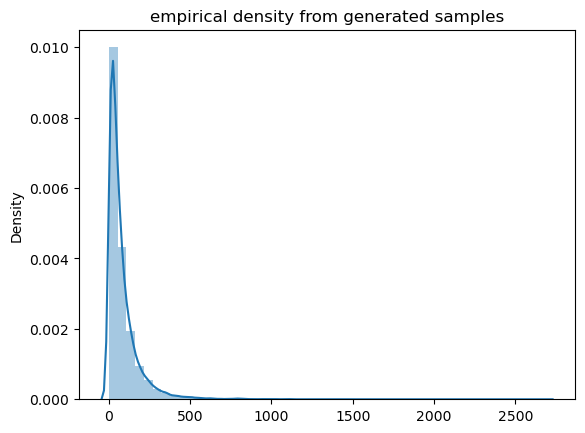

/tmp/ipykernel_92176/2358292155.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_set)


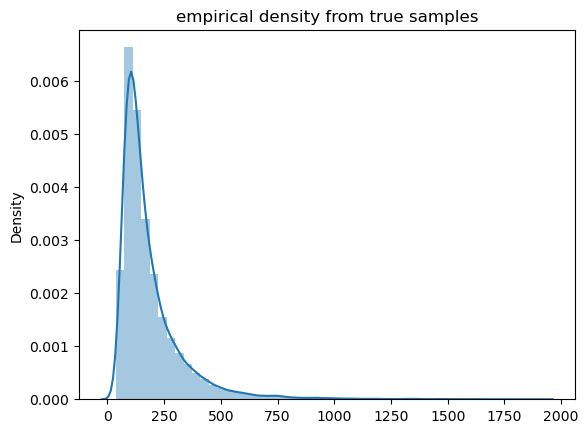

In [5]:
sns.distplot(samples_vae)
plt.title("empirical density from generated samples")
plt.show()

sns.distplot(test_set)
plt.title("empirical density from true samples")
plt.show()


### QQ plot and log-QQ plot

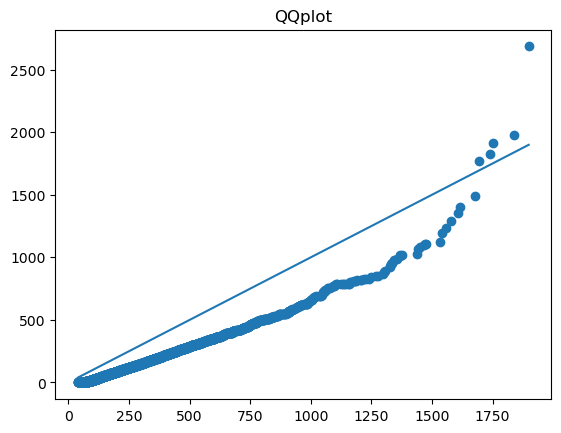

In [6]:
# QQ plot
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(test_set[:,0]),tf.sort(samples_vae))
plt.plot(tf.sort(test_set[:,0]),tf.sort(test_set[:,0]))


In [78]:
#Log QQ plot above quantile q

q = 0.9
N = q*N_samples

plt.figure()
plt.title('log-QQplot')
plt.scatter(tf.math.log(tf.sort(test_set)[N:]),tf.math.log(tf.sort(samples_vae1)[N:]))
plt.scatter(tf.math.log(tf.sort(test_set)[N:]),tf.math.log(tf.sort(samples_vae2)[N:]))
plt.scatter(tf.math.log(tf.sort(test_set)[N:]),tf.math.log(tf.sort(samples_vae3)[N:]))
plt.plot(tf.math.log(tf.sort(test_set)[N:]),tf.math.log(tf.sort(test_set)[N:]))

NameError: name 'samples_vae1' is not defined

### KL divergence upon a threshold

tf.Tensor(2.1270897, shape=(), dtype=float32)
KL divergence upon threshold 0.9 :  0.7135027826327598


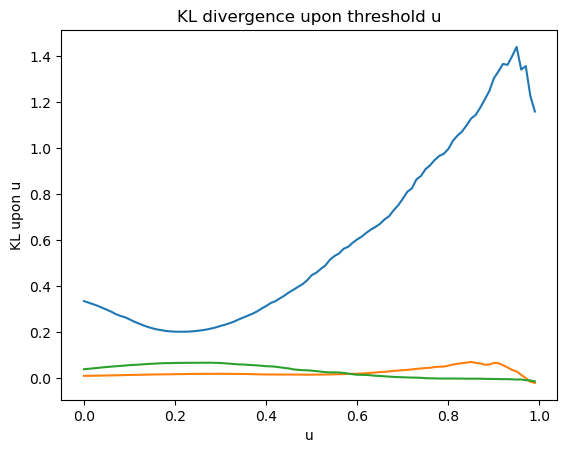

In [70]:
# Threshold corresponding to quantile q
q = 0.9
u=tf.sort(test_set)[int(q*N_samples)]
print(u)
print(f"KL divergence upon threshold {q} :  {K(test_set,samples_vae1,u)}")

X = np.arange(0,1,0.01)
Ind = X*10000
Ind = Ind.astype('int64')

Q = np.sort(samples_vae1)[Ind]
#Q = np.sort(test_set)[Ind]

Q2 = np.sort(samples_vae2)[Ind]
Q3 = np.sort(samples_vae3)[Ind]

Y  = [K(test_set,samples_vae1,qi) for qi in Q]
Y2 = [K(test_set,samples_vae2,qi) for qi in Q2]
Y3 = [K(test_set,samples_vae3,qi) for qi in Q3]
plt.figure()
plt.title("KL divergence upon threshold u")
plt.xlabel("u")
plt.ylabel("KL upon u")
plt.plot(X,Y)
plt.plot(X,Y2)
plt.plot(X,Y3)

### VAE score on test set

In [29]:
data_test = tf.reshape(test_set,(N_samples,1))
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae_test.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)
vae_test.evaluate(data_test,data_test,batch_size=32)

313/313 [==============================] - 2s 4ms/step - loss: 1.6537


1.6536592245101929

### Statistical insights in R1 : tail index estimation

##### Hill plot

In [4]:
def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """    
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
        
        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax
  
    kappa = 1. / Hill_est
    return kappa

In [5]:
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

165.50166
16.883898


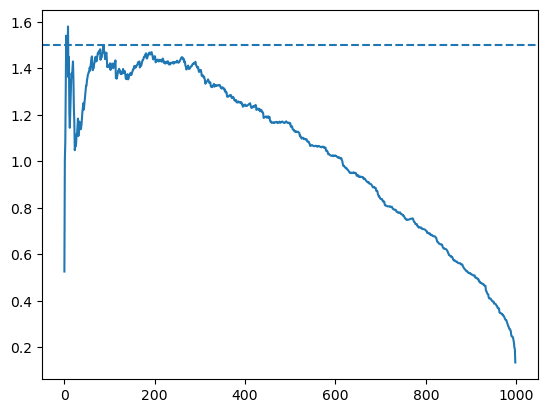

In [6]:
H = Hill_estimator(R1)
plt.plot(H)
plt.axhline(1.5, linestyle='--')


##### Moments estimation

In [35]:
xi = scipy.stats.genpareto.fit(tf.sort(R1)[950:])[0]
alpha_moments = 1/xi
print(alpha_moments)

1.6573943799753574


# Angle experiment

### Samples on the simplex from the true distribution

In [3]:
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3.*tf.minimum(1.,0.5/x), 6. -3.*tf.minimum(1.,0.5/x) , 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x)])
    return(tf.transpose(res))


alphas          = alphas_function(test_set)
angle_train_dep = tfd.Dirichlet(alphas).sample()

NameError: name 'test_set' is not defined

In [7]:
Ind       = tf.argsort(test_set)
R1_sort   = test_set[Ind]
angle_dep = angle_train_dep.numpy()[Ind]

## Independence between radius and angle 

In [ ]:
nbq = 100
qmax=0.01
qmin=0.3
m=60
L=200

qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]

for i in range(nbq):
    print(i)
    pvi = 0
    q = qk[i]
    indq =int((1-q)*10000)
    n = int(nk[i])
    r = R1_sort[indq]
    print(r)
    print(q)
    Rq = R1_sort[indq:]/r
    angle = angle_dep[indq:]
    Nq = 10000-indq
    start=datetime.now()
    for k in range(m):
        IndS = tf.random.shuffle(tf.range(start=0, limit=Nq, dtype=tf.int32))[:n]
        RqS_joint = tf.gather(Rq,IndS)
        RqS_joint = tf.reshape(RqS_joint,(n,1))
        angleS_joint = tf.gather(angle,IndS)
        T_emp = T(RqS_joint,angleS_joint,int(n))
        pvk=0
        for j in range(L):
            RqS_ind=tf.random.shuffle(Rq)[:int(n)]
            RqS_ind = tf.reshape(RqS_ind,(n,1))
            angleS_ind = tf.random.shuffle(angle)[:int(n)]
            T_ind = T(RqS_ind,angleS_ind,int(n))
            pvk+= T_emp.numpy()<(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    print(datetime.now()-start)
    pvi = pvi/m
    res.append(pvi)
    print(qk[i])
    print(pvi)

0
12.701063
0.01
0:00:58.516064
0.01
0.53275
1
10.555375
0.01291
0:01:00.578204
0.01291
0.47050000000000003
2
8.9409685
0.01582
0:01:00.781549
0.01582
0.4230833333333334
3
8.025676
0.018729999999999997
0:01:00.844964
0.018729999999999997
0.4702500000000001
4
7.2089252
0.02164
0:01:00.852937
0.02164
0.5030833333333332
5
6.415419
0.024549999999999995
0:01:01.057911
0.024549999999999995
0.5036666666666668
6
5.8905897
0.02746
0:01:01.296883
0.02746
0.5389166666666666
7
5.490703
0.030369999999999994
0:01:02.478390
0.030369999999999994
0.47574999999999995
8
5.1781063
0.03328
0:01:04.707814
0.03328
0.5020833333333334
9
4.7861643
0.03618999999999999
0:01:06.363944
0.03618999999999999
0.5740000000000001
10
4.469511
0.039099999999999996
0:01:06.608985
0.039099999999999996
0.43891666666666646
11
4.281248
0.04201
0:01:07.420417
0.04201
0.49900000000000005
12
4.0315223
0.044919999999999995
0:01:07.687565
0.044919999999999995
0.5510833333333333
13
3.8268318
0.04782999999999999
0:01:08.547789
0.04782

### Density on the simplex given radius projected on 2 axis 

##### For true distribution

In [45]:
ax0      = 3
ax1      = 4

rad      = 3 # value of the considered radius
Diri_rad = tfd.Dirichlet(alphas_function(rad))

(1000,)
(1000,)


/tmp/ipykernel_83088/969063099.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([angles_x1,angles_x2])


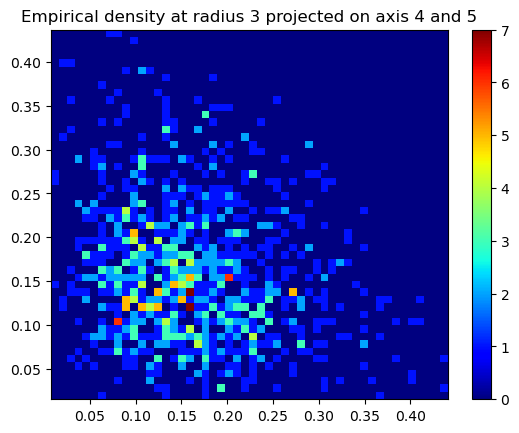

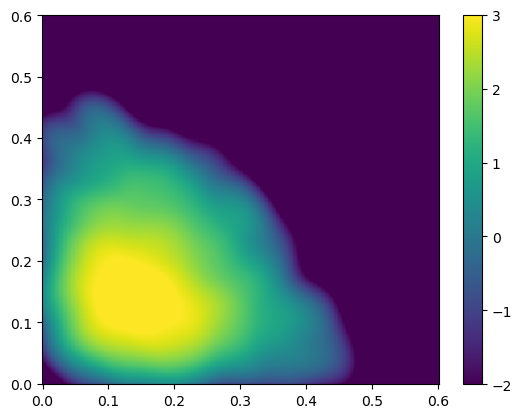

In [46]:
#plot density at given radius r  
angles    = Diri_rad.sample(1000).numpy()
angles_x1 = angles[:,ax0]
print(angles_x1.shape)
angles_x2 = angles[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))

from matplotlib.colors import Normalize
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()


##### For our approach

In [39]:
# Loading model
checkpoint_path = '/home/nlafon/These/Extreme_VAE/tmp/sphere_radius1/diri_output/checkpoint'
import Prob_models as PM
vae_sphere = PM.Sphere_VAE()
vae_sphere.load_weights(checkpoint_path)

In [47]:
# Generate samples
prior_samples = vae_sphere.encoder.prior.sample(1000)
angles_dist   = vae_sphere.decoder([prior_samples,rad*tf.ones((1000,1))])
angles_gen    = angles_dist.sample()
print(angles_gen.shape)
angle_gen     = angles_gen/tf.reshape(tf.reduce_sum(angles_gen,axis=1),(1000,1))

(1000, 5)


(1000,)
(1000,)


/tmp/ipykernel_83088/3730848380.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([angles_x1,angles_x2])


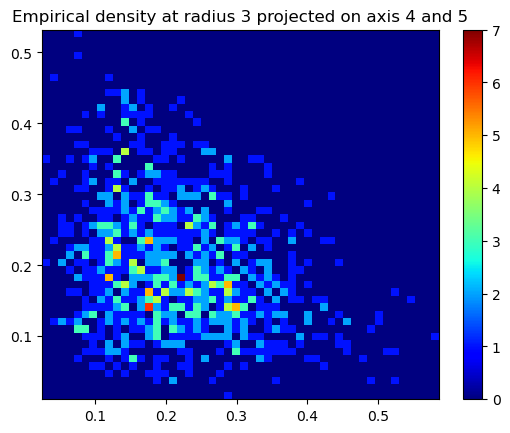

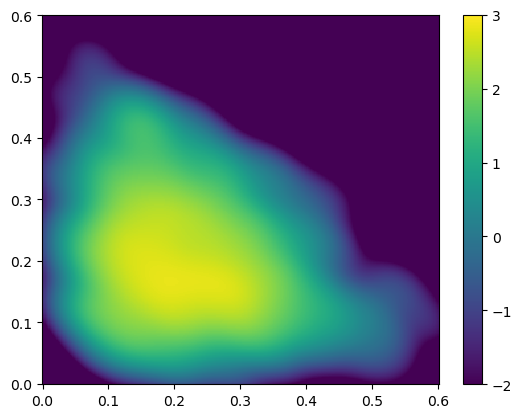

In [48]:
# Plot the density map
angles_x1 = angles_gen.numpy()[:,ax0]
print(angles_x1.shape)
angles_x2 = angles_gen.numpy()[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto',norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()


### KL divergence between true angular distribution  at given radius and estimated one

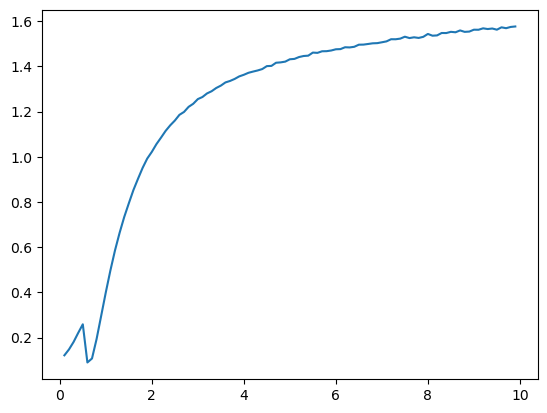

In [56]:
res   = []
R     = []
step  = 0.1
mini  = 0.1 
start = 0.1
maxi  = 10 
nstep = int((maxi-mini)/step)
r     = start

for i in range(nstep):   
    diri_true     = tfd.Dirichlet(alphas_function(r))
    prior_samples = vae_sphere.encoder.prior.sample(1000)
    angles_dist   = vae_sphere.decoder([prior_samples,r*tf.ones((1000,1))])
    kl_estimate   = tfd.kl_divergence(angles_dist, diri_true)
    res.append(tf.reduce_mean(kl_estimate))
    R.append(r)
    r            += step

plt.plot(R,res)


# Danube experiment

### Proportion of elements verifying conjugate extremes in train and test set

In [7]:
R4_23 = np.sort(R4[:,0])
R4_24 = np.sort(R4[:,1])
R4_25 = np.sort(R4[:,2])
R4_26 = np.sort(R4[:,3])
R4_27 = np.sort(R4[:,4])

q = 0.99
n = int(q*18244)

print(R4_23[n])
print(R4_24[n])
print(R4_25[n])
print(R4_26[n])
print(R4_27[n])

U1 = R4[:,0]>R4_23[n]
U2 = R4[:,1]>R4_24[n]
U3 = R4[:,2]>R4_25[n]
U4 = R4[:,3]>R4_26[n]
U5 = R4[:,4]>R4_27[n]
print(np.sum(U1*U2)/18244)
print(np.sum(U1*U3)/18244)
print(np.sum(U1*U4)/18244)
print(np.sum(U1*U5)/18244)
print(np.sum(U2*U3)/18244)

print(np.sum(U2*U4)/18244)
print(np.sum(U2*U5)/18244)
print(np.sum(U3*U4)/18244)
print(np.sum(U5*U3)/18244)
print(np.sum(U5*U4)/18244)

print(np.sum(U1*U2*U3)/18244)
print(np.sum(U1*U2*U3*U4)/18244)
print(np.sum(U2*U3*U4*U5)/18244)
print(np.sum(U1*U2*U3*U4*U5)/18244)
#print(np.count_nonzero(R4[:,0]>R4_23[n] & R4[:,1]>R4_24[n]))

train_dataset = R4[::25,:]
print(train_dataset.shape)


U1 = train_dataset[:,0]>R4_23[n]
U2 = train_dataset[:,1]>R4_24[n]
U3 = train_dataset[:,2]>R4_25[n]
U4 = train_dataset[:,3]>R4_26[n]
U5 = train_dataset[:,4]>R4_27[n]
print(np.sum(U1*U2)/730)
print(np.sum(U1*U3)/730)
print(np.sum(U1*U4)/730)
print(np.sum(U1*U5)/730)
print(np.sum(U2*U3)/730)
print(np.sum(U2*U4)/730)
print(np.sum(U2*U5)/730)
print(np.sum(U3*U4)/730)
print(np.sum(U5*U3)/730)
print(np.sum(U5*U4)/730)

print(np.sum(U1*U2*U3)/730)
print(np.sum(U1*U2*U3*U4)/730)
print(np.sum(U2*U3*U4*U5)/730)
print(np.sum(U1*U2*U3*U4*U5)/730)

215.0
184.0
169.0
150.0
114.0
0.00893444420083315
0.004878316158737119
0.004275378206533655
0.002905064678798509
0.005207191405393554
0.0044398158298618725
0.0031243148432361324
0.007618943214207411
0.004659065994299496
0.006084192063144048
0.0047686910765183076
0.0040013155009866255
0.002740627055470292
0.0025213768910326683
(730, 5)
0.00410958904109589
0.0
0.0
0.0013698630136986301
0.0
0.0
0.0013698630136986301
0.0013698630136986301
0.0
0.0013698630136986301
0.0
0.0
0.0
0.0


### Sample on the simplex for Danube dataset

In [13]:

checkpoint_path  = '/home/nlafon/These/Extreme_VAE/tmp/Danube/angle/normal_output2/checkpoint'

vae_ang          = PM.Sphere_VAE()
vae_ang.load_weights(checkpoint_path)
#size             = samples_vae.shape[0]
size = 18244
prior_samples = vae_ang.encoder.prior.sample((size))
samples_vae = tf.reshape(samples_vae,(18244,1))

angles_dist   = vae_ang.decoder([prior_samples,samples_vae[:size]])
angles_gen    = angles_dist.sample()
print(angles_gen.shape)
angles_gen    = np.divide(angles_gen,np.sum(angles_gen,1).reshape(size,1))

(18244, 5)


In [14]:
genD = (angles_gen*samples_vae).numpy()
print(genD.shape)

(18244, 5)


### Proportion of elements verifying conjugate generated dataset

In [16]:
q = 0.9
n = int(q*18244)

print(R4_23[n])
print(R4_24[n])
print(R4_25[n])
print(R4_26[n])
print(R4_27[n])

U1 = genD[:,0]>R4_23[n]
U2 = genD[:,1]>R4_24[n]
U3 = genD[:,2]>R4_25[n]
U4 = genD[:,3]>R4_26[n]
U5 = genD[:,4]>R4_27[n]
print(np.sum(U1*U2)/18244)
print(np.sum(U1*U3)/18244)
print(np.sum(U2*U3)/18244)
print(np.sum(U2*U4)/18244)
print(np.sum(U2*U5)/18244)
print(np.sum(U3*U4)/18244)
print(np.sum(U5*U3)/18244)
print(np.sum(U5*U4)/18244)
print(np.sum(U1*U4)/18244)
print(np.sum(U1*U5)/18244)
print(np.sum(U1*U2*U3)/18244)
print(np.sum(U1*U2*U3*U4)/18244)
print(np.sum(U2*U3*U4*U5)/18244)
print(np.sum(U1*U2*U3*U4*U5)/18244)
#print(np.count_nonzero(R4[:,0]>R4_23[n] & R4[:,1]>R4_24[n]))

96.5
78.6
69.0
62.1
47.6
0.015621574216180663
0.019568077176057883
0.016937075202806403
0.01710151282613462
0.015895636921727692
0.022856829642622232
0.021157640868230652
0.021596141197105897
0.02011620258715194
0.019129576847182635
0.014799386099539574
0.01419644814733611
0.014306073229554923
0.012935759701819776
